In [24]:
### import modules 
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mdtraj as md
os.chdir('/Users/musti/Desktop/AsN/BME')
directory_to_bme = os.getcwd()[:-8] # set correct path to BME
sys.path.append(directory_to_bme)
import bme_reweight as bme
from uncertainties import ufloat

# 1 Calculating Rg and Rh
Now that we have loaded all the required modules, we can load a trajetory in MDtraj and calculate the Rg for each frame. The ensemble we load here, consist of 32000 frames sampled with Campari and described in main paper as Ensemble 1. 
We use Equation 3 in the main text to convert Rg values to Rh. 
Eq. 3 is parameterized using C-alpha atoms, so we only select the C-alpha atoms before converting.

We do all our calculation in  angstroms, since the parameters in Eq. 3 are in angstroms.


### Due to its size, we do not provide the trajectory in the Github repository. This is the code that we used to  generate the Rg values from the trajectory (which are read below). 

In [25]:
##  MDtraj loading trajectory and calculating Rg  
traj = md.load("a99SB-disp_extended/cat_traj.trr",top="a99SB-disp_extended/system.pdb") # Load trajectory and structure file
CA_atoms = traj.topology.select('name CA')         # Selecting C-alpha atoms 
traj.atom_slice(CA_atoms, inplace=True)
rg = md.compute_rg(traj)                          
  
Rg = np.reshape(np.array(rg*10),[-1, 1])    # Converting Rg from nm to Angstrom
print (len(Rg))
np.savetxt('a99SB-disp_extended/Rg_calc.dat', rg)                      # Saves Rg values to the file "Rg_calc.dat"

73117


We instead load Rg values from a file we pre calculated using the method above:

In [26]:
#traj = md.load('a03ws/traj.trr') #just used to get the number of residues                
#Rg = np.loadtxt('../data/calc_Rg.txt')
print(len(Rg))

73117


We now calculate Rh for each frame, using equation 3 from Nygaard et al.
and print the ensemble average Rg and Rh of the trajectory.
We futher calculate 1/Rh and I(Rh) for use in BME reweighting.


In [27]:
# Number of amino acids in protein
N = traj.n_residues

# Function for Rh, 1/Rh and I_Rh  calculation
def getRh(rg,N):
    # Parameters fitted in Nygaard et al.
    a1=0.216
    a2=4.06 
    a3=0.821
    return (rg)/((a1*(rg-a2*N**(0.33)))/(N**(0.60)-N**(0.33))+a3)

def inversRh(rh):
    return 1./rh


def getIRh(rh):
    return np.exp(-1./rh)


# Rh calculation   
Rh = getRh(Rg,N)

# 1/Rh calculation
Rh_inv = inversRh(Rh)


# I_Rh calculation   
I_Rh = getIRh(Rh)
np.savetxt('a99SB-disp/RH_calc.dat', Rh)
# Print the ensemble average Rg and Rh
print('Initial <Rg^2>^1/2: {:.2f},  Initial <1/Rh>^-1: {:.6f}'.format(np.sqrt(np.mean(Rg*Rg)),np.mean(1/Rh)**(-1)))
print('Initial <Rg>:       {:.2f},  Initial <Rh>:      {:.6f}'.format((np.mean(Rg)),np.mean(Rh)))
print('Initial <Rh> = -1/log(<IRh>):      {:.6f}'.format(-1./np.log(np.mean(I_Rh))))

# Save and structure 1/Rh values for BME input file 
with open('calc_Rh_inv.txt', 'w') as program:
    for (number, line) in enumerate(Rh_inv):
        program.write('%d  %s\n' % (number + 1, line))
        
# # Save and structure I_Rh values for BME input file 
# with open('../data/calc_Irh.txt', 'w') as program:
#     for (number, line) in enumerate(I_Rh):
#         program.write('%d  %s\n' % (number + 1, line))
# sns.set_style("ticks")
# sns.set_context("paper")
# ax = sns.distplot(Rg, rug=False, hist=False,kde=True, label='Rg dist')
# ax1 = sns.distplot(Rh, rug=False, hist=False,kde=True, label='Rh dist', color='orange')
# plt.axvline(np.mean(Rg), 0,.5,label='<Rg^2>^1/2 = 25.6 Å',ls='--')
# plt.axvline(np.mean(Rh), 0,.5,label='<1/Rh>^-1 = 27.7 Å', c='orange',ls='--')
# ax.set_ylim(-.001,0.2)
# ax.set_ylim(-.001,0.2)
# print(np.mean(Rg))
# plt.legend()



Initial <Rg^2>^1/2: 25.60,  Initial <1/Rh>^-1: 27.699224
Initial <Rg>:       25.06,  Initial <Rh>:      28.002418
Initial <Rh> = -1/log(<IRh>):      27.704316


As seen above there are diffrent ways of averaging the calculated values Rg and Rh.
Here we will reweight the enseble with intensity e.g `I(Rh)`, and thus only use the average method `(-1/log(Rh))` for Rh average. But we have also prepared BME input files for `1/Rh` and show the linear averging of Rh in case one will need that. 


In [28]:
### Experimental Rg and Rh and error values

Rg_Exp= ufloat(35.5,0.5) 
Rh_Exp= ufloat(28.6,0.7)
print(Rg_Exp.nominal_value)
Rh_invs=1/Rh_Exp
I_rh=2.718**(-1./Rh_Exp)
print('Rh_inv = ',Rh_invs)
print('I_rh = ',I_rh)
import pandas as pd



35.5
Rh_inv =  0.0350+/-0.0009
I_rh =  0.9656+/-0.0008


# 2 BME Input data and how it is structured
In this example we will only be showing the input files for the SAXS input files. Incase you need to rewight with data such as RDC, NOE, jcouplings ect. please read the source code and paper for BME avalible at https://github.com/KULL-Centre/BME

Here we have already prepared the input files `exp_Irh.txt`, `exp_saxs.txt` and `calc_saxs.txt` for you.

BME takes two different types of input files for the reweighting: 

(I) An experimental file e.g `exp_saxs.txt`

(II) A file with calculated values of the same experimental observable e.g `calc_saxs.txt` 


We start by first looking at the format of the experimental file  :

In [29]:
#Experimental SAXS input file
%cat a99SB-disp_extended/saxs_exp.dat 
#saxs = 'saxs_exp.dat'

# DATA=SAXS PRIOR=GAUSS
0.009738 1650.54700000 49.55999000
0.010014 1692.98300000 47.96958000
0.010291 1683.81600000 45.25286000
0.010568 1662.73500000 46.08175000
0.010844 1667.99900000 42.03713000
0.011121 1711.51800000 41.46148000
0.011398 1616.87400000 40.95227000
0.011674 1683.30200000 38.56311000
0.011951 1658.03300000 38.52197000
0.012227 1654.74500000 36.39113000
0.012504 1671.16200000 36.52881000
0.012781 1603.54200000 35.80615000
0.013057 1622.29500000 33.58010000
0.013334 1644.23300000 34.05535000
0.013611 1653.98800000 32.67268000
0.013887 1618.53300000 32.52369000
0.014164 1570.14000000 32.12568000
0.014441 1598.79000000 30.41514000
0.014717 1567.64100000 31.04689000
0.014994 1591.01300000 29.90682000
0.015270 1590.12600000 29.39522000
0.015547 1551.11000000 28.99496000
0.015824 1605.15800000 28.47594000
0.016100 1565.19700000 28.35612000
0.016377 1613.66700000 27.53736000
0.016654 1545.01700000 27.18820000
0.016930 1569.19000000 27.03812000
0.017207 1505.25100000 26.80130

The first line in the file is a header that defines the type of data and the error model it should use. BME has  only gaussain error model implemented(may 2019). However, BME allows  simultaneous use of several heterogeneous data(e.g. SAXS, NOE, Chemical Shifts, Residual Couplings) for reweighting.

In column 1, 2 and 3 we have the experimental value of the: scatter vector, intensity and error, respectively. The number of the rows is equal to the number of data points. In this case 179.  

Note: Units are not relevant as long as they are all consistent in the experimental and calculated data file.


The corresponding calculated data file(`saxs_calc.txt`)looks like this (only showing the first two rows for the pupose of saving screen real estate):

In [30]:
# Calculates  SAXS input
%cat a99SB-disp_extended/saxs_calc.dat | head -2

1 1271.81156139 1269.75001325 1267.68850453 1265.62595832 1263.56107265 1261.49478452 1259.42504407 1257.35279178 1255.27672480 1253.19553473 1251.11017031 1249.01932483 1246.92168363 1244.81820731 1242.70681906 1240.58848939 1238.46190114 1236.32572517 1234.18094988 1232.02624941 1229.86028353 1227.68406213 1225.49624885 1223.29549055 1221.08282224 1218.85608803 1216.61634169 1214.36222532 1212.09236024 1209.80783134 1207.50726539 1205.18926597 1202.85495272 1200.50208167 1198.13179764 1195.74269783 1193.33335222 1190.90494638 1188.45605736 1185.98523256 1183.49370194 1180.97910772 1178.44271147 1175.88305259 1173.29863684 1170.69077619 1168.05798506 1165.39874180 1162.71441239 1160.00348445 1157.26440711 1154.49860400 1151.70351879 1148.88061555 1146.02833319 1143.14506811 1140.23234805 1137.28858027 1134.31212712 1131.30458361 1128.26321844 1125.18967348 1122.08229924 1118.93942667 1115.76335069 1112.55345342 1109.30908507 1106.03311953 1102.72371717 1099.38379887 1096.01270309 1092

`calc_saxs.txt` has 180 columns. The first column being intended for labelling the row( eq. `frame_1.pdb`), and then one column per experimental average, we have in total 179. The number of rows depends on how many structures/frames you have in the ensemble. In this case, we have 10.000 frames in this case.

# 3 BME reweighting and  θ selection
We here show how to apply the BME reweighting procedure. Essentially, there are only three fundamental steps:

1. Initialize the class
2. Load the data
3. Optimize


We start by showing how to Initialize the BME and load the data. Then, in order to find a viable value for the θ parameter,  we scan different values of θ and plot $\chi^2_{re}$ and the total $\chi^2$ versus the fraction of effective frames ($N_{eff} = exp(S_{rel})$).:

In [31]:
###### BME reweighting 

### Read experimental and calculated data files.                                                                        
exp_saxs = 'a99SB-disp_extended/saxs_exp.dat'
calc_saxs = 'a99SB-disp_extended/saxs_calc.dat'        # Remember to decompress before loading!!
# exp_Rh_inv = '../data/exp_Rh_inv.txt'
# calc_Rh_inv = '../data/calc_Rh_inv.txt'
#exp_Irh = '../data/exp_Irh.txt'
#calc_Irh = '../data/calc_Irh.txt'


### initialize reweighting class                                                                                                                                
rew = bme.Reweight()

### load SAXS data                                                                                      
rew.load(exp_saxs,calc_saxs)

### load Rh data                                                                                      
#rew.load(exp_rh,calc_rh)

### load I_rh data                                                                                      
#rew.load(exp_Irh,calc_Irh)

### do minimization for different values of theta
thetas= [50.,400, 1000,2000,3000,4000,6000]
results = []
for t in thetas:
    # do the minimization
    chi2_saxs_before,chi2_saxs_after, srel = rew.optimize(theta=t)

    # calculate agreement with SAXS and Rh, and write output to a temporary file
    #chi2_Irh_before,chi2_Irh_after = rew.weight_exp(exp_saxs,calc_saxs,"tmp")
    #chi2_saxs_before,chi2_saxs_after = rew.weight_exp(exp_saxs,calc_saxs,"tmp1")
    results.append( [np.exp(srel),chi2_saxs_before,chi2_saxs_after])


# exp data: (688, 2)
# calc data: (73117, 688)
# exp data: (688, 2)
# calc data: (73117, 688)
# exp data: (688, 2)
# calc data: (73117, 688)
# exp data: (688, 2)
# calc data: (73117, 688)
# exp data: (688, 2)
# calc data: (73117, 688)
# exp data: (688, 2)
# calc data: (73117, 688)
# exp data: (688, 2)
# calc data: (73117, 688)


# 4 Figures
### We now plot figure 2 in the main text 

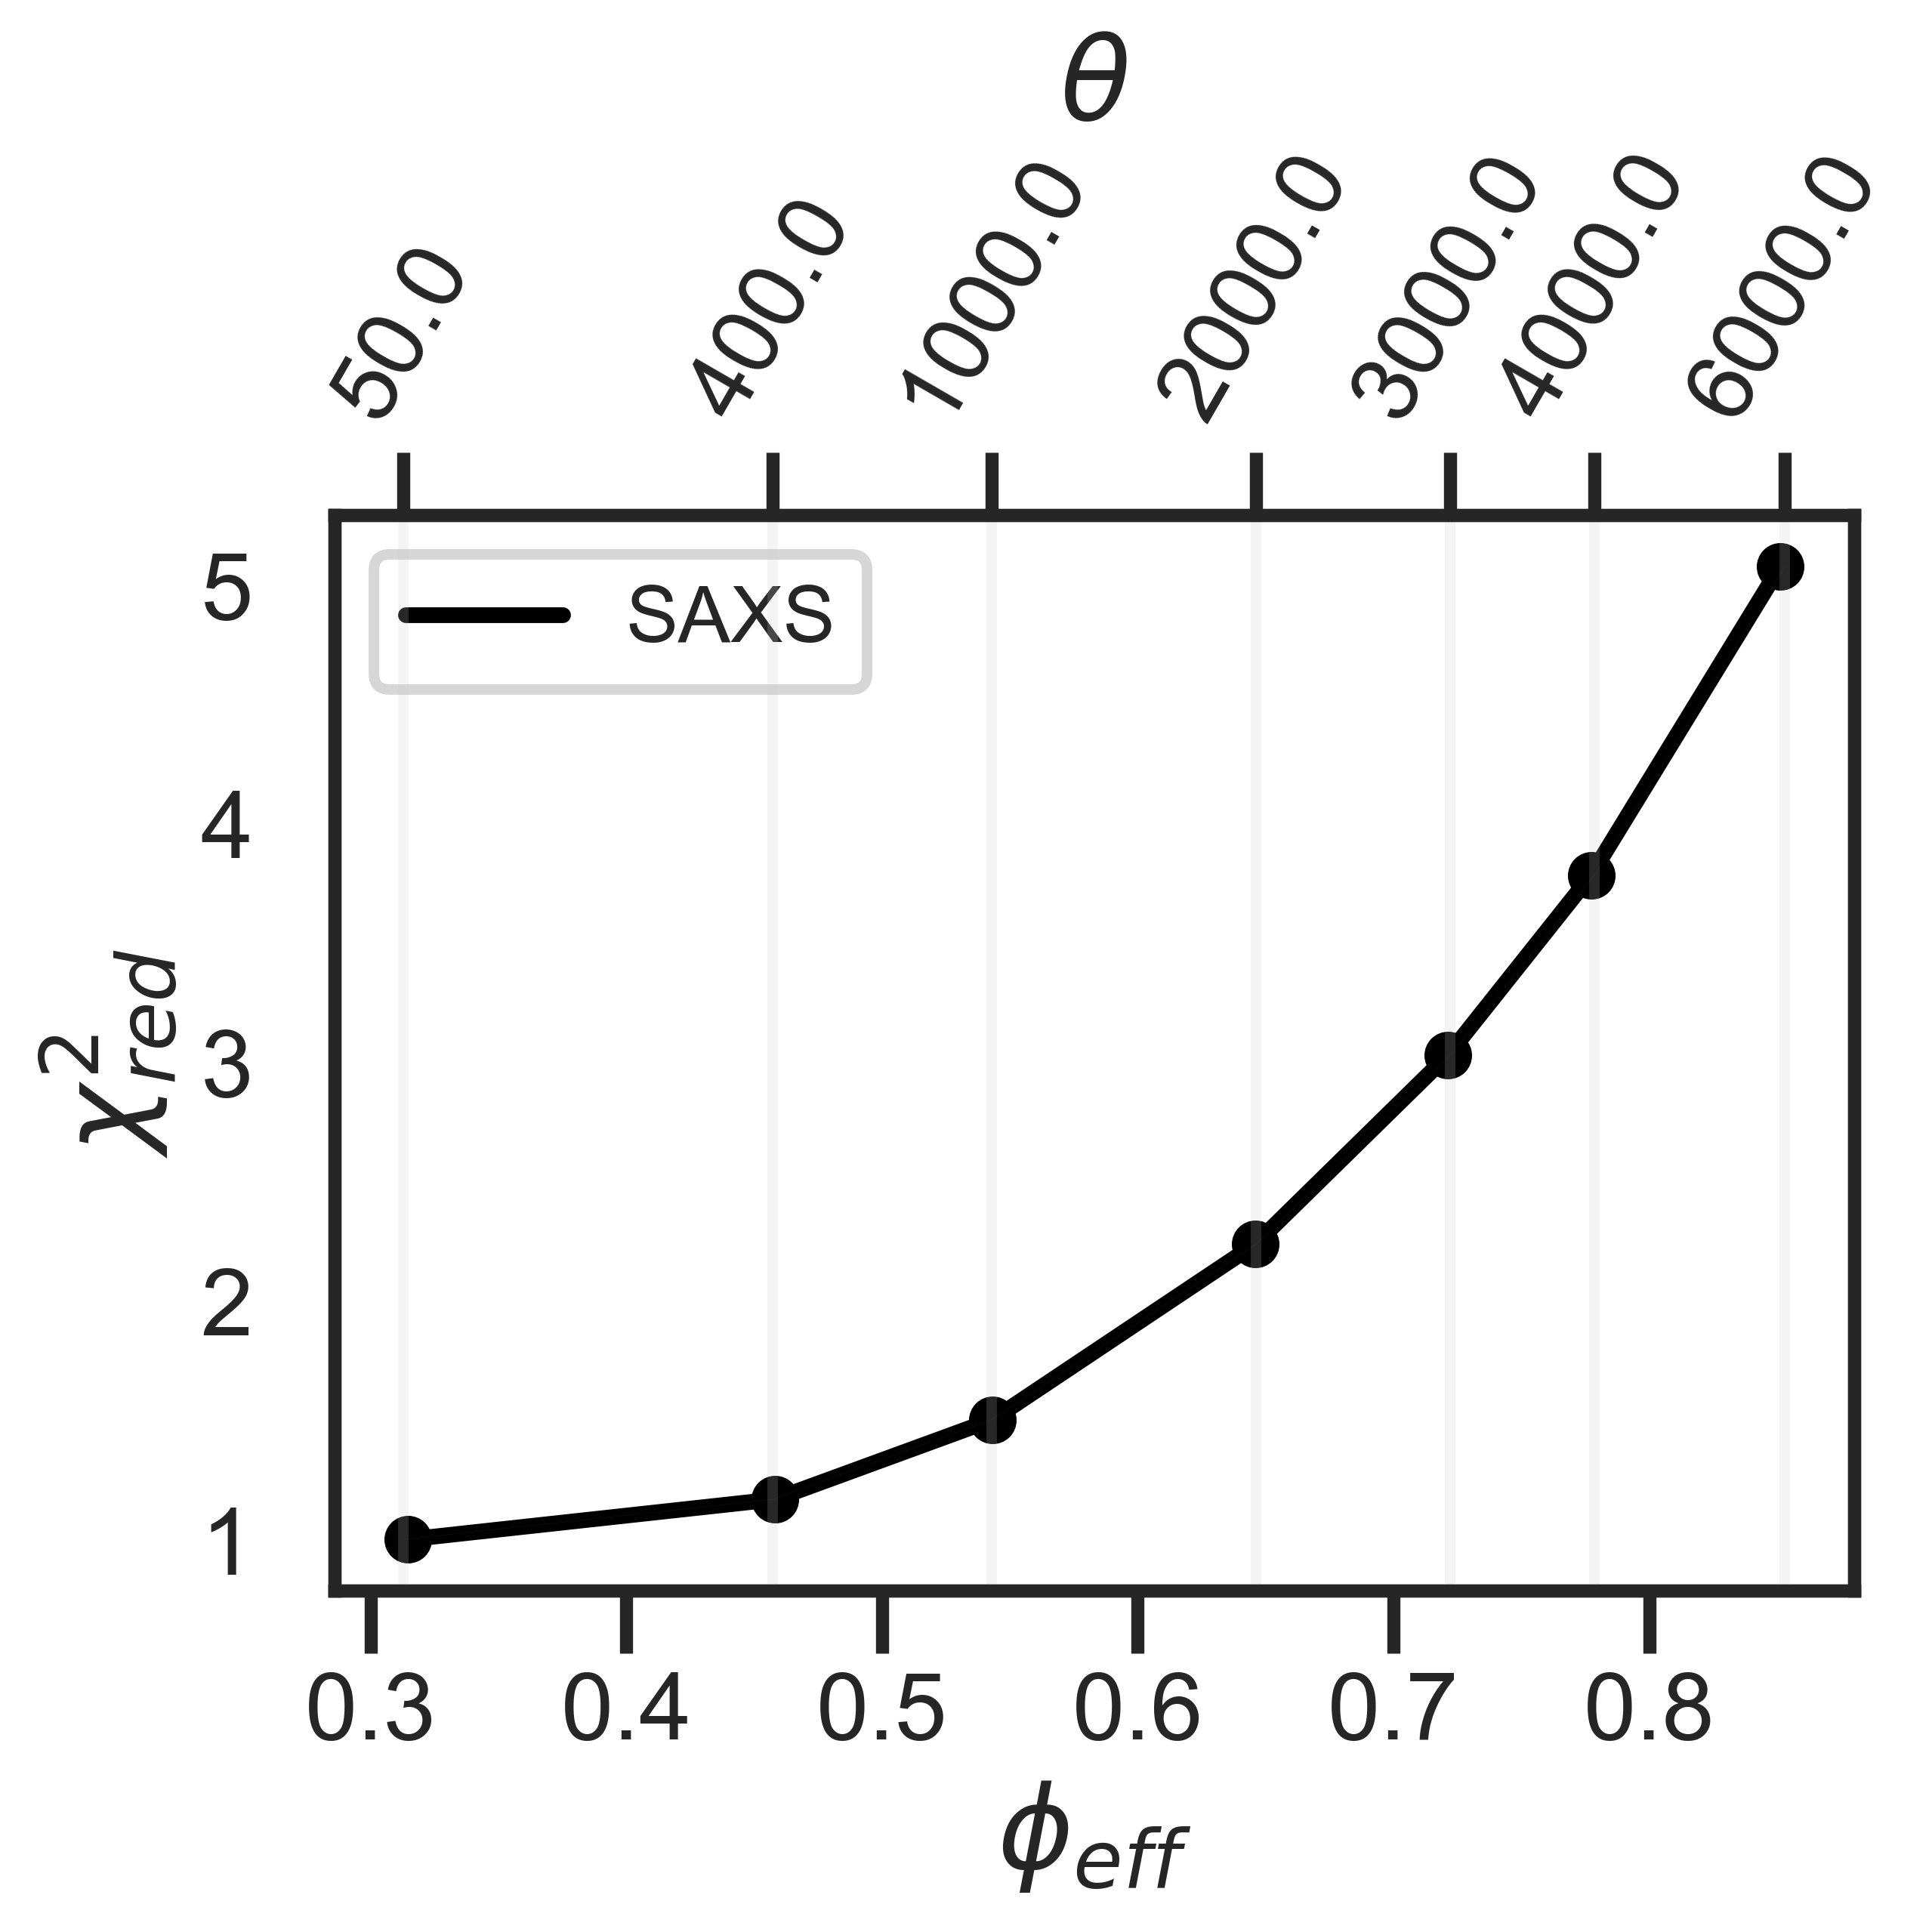

In [32]:
### Plot figure for different values of theta vs Neff and chi^2
sns.set_style("white")
sns.set_context("poster")
# handling tickers and read data
from matplotlib.ticker import NullFormatter
from matplotlib import ticker
import matplotlib as mpl
mpl.rcParams['figure.dpi'] =500
results = np.array(results)

# define the figure
fig, ax1 = plt.subplots(1,1,figsize=(5, 5))

# plot SAXS and Rh
#ax1.plot(results[:,0],results[:,1],label="before",c='#C1CDCD',ls="-",lw=3)
ax1.plot(results[:,0],results[:,2],label="SAXS",c='k',ls="-",lw=3)

# set tickers
ax1.set_xticks([0,0.1,0.2,0.3,0.4,0.5,.6,0.7,0.8,0.9,1.0])
ax1.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax1.xaxis.set_major_formatter(ticker.FormatStrFormatter("%3.1f"))
ax1.xaxis.set_minor_formatter(ticker.NullFormatter())

# Make a new horizontal axis to show the theta values and a new vertical axis to show the chi^2 total
ax2 = ax1.twiny()
ax2.plot(results[:,0],results[:,2],c='grey',lw=0.01)
#ax3 = ax1.twinx()
#ax3.plot(results[:,0],results[:,2]*180,label="SAXS,$IR_h$",c='#C1CDCD',lw=3)

#draw ticks at selected theta
sele = thetas= [50.,400, 1000,2000,3000,4000,6000]
iis = [thetas.index(s) for s in  sele]
ax2.set_xticks(results[iis,0])
ax2.set_xticklabels(["%.1f"% s for s in sele],rotation=60)
ax1.scatter(results[iis,0],results[iis,2],c='k',s=50)
#ax1.scatter(results[iis,0],results[iis,2],c='k')
#ax3.scatter(results[iis,0],results[iis,2]*180,c='#C1CDCD')
plt.rcParams.update({'legend.fontsize':15})
ax2.xaxis.set_minor_locator(ticker.MultipleLocator(5))
plt.rcParams['figure.constrained_layout.use'] = True
#ax3.xaxis.set_minor_locator(ticker.MultipleLocator(10))
#ax3.set_ylabel(r"$\chi^2$", color='#C1CDCD',fontsize=22)
ax1.set_xlabel("$\phi_{eff}$",fontsize=22)
ax2.set_xlabel(r"$\theta$",fontsize=22)
ax1.set_ylabel(r"$\chi^2_{red}$",fontsize=22)
ax1.tick_params(axis='both', labelsize=18)
ax2.tick_params(axis='both', labelsize=18)
ax1.legend()
plt.grid(alpha=0.2)
name='a99SB-disp/' + 'theta' + '.png' 
plt.savefig(name,dpi=500)
plt.show()



Based on the L-curve plot above(grey), one would choose the elbow region as an optimal $\theta$. The elbow region is where further decrease in $\theta$  will not result in significant decrease in the associated $\chi^2$.  Here a $\theta$ between $70$ to $200$ will suffice. In our example we have used $\theta=100$. 

after choosing a theta we can look at how  $\chi^{2}_{re}$  lower after the reweighting:

In [33]:
# selected theta=
chi2_before,chi2_after, trel = rew.optimize(theta=1000)

print("# CHI2_re before minimization:     {:8.4f}".format(chi2_before))
print("# CHI2_re after minimization:      {:8.4f}".format(chi2_after))
print("# Fraction of effective frames:    {:8.4f}".format(np.exp(trel)))


# exp data: (688, 2)
# calc data: (73117, 688)
# CHI2_re before minimization:      12.2781
# CHI2_re after minimization:        1.5057
# Fraction of effective frames:      0.5431


##### The $\chi^2_{re}$ drops from 2.24 to 0.38 after rewighting with $\theta=100$. We are also effectively using ~63 % of the initial frames . 

Now that we have new weights it is very easy to calculate any average/distribution of interest.

We now plot the distribution Rg and Rh after and before reweighting using $\theta=100$. 
but first start by block averaging the data. We do this to estimate the error, and also get an indication of the convergence of the observable we are calculating:


In [34]:
##### Block averaging and plot figure   

### Set bins for block average and optimal theta to use
n_frames = len(Rg)
n_bins=1
bin_size = n_frames//n_bins
bins = np.arange(0,n_frames+bin_size,bin_size)
theta=1500


### split in 5 blocks
for j in range(len(bins)-1):

    rows = np.arange(bins[j],bins[j+1])
    rew = bme.Reweight()
    rew.load(exp_saxs,calc_saxs,rows=rows)
#    rew.load(exp_Irh,calc_Irh,rows=rows)
    rew.optimize(theta=theta)
    
    rew.weight_exp(exp_saxs,calc_saxs, 'a99SB-disp/example2_{}_'.format(j),rows=rows)

    w_opt = rew.get_weights()

    ### write weights to file
    w0 = [1./len(w_opt)]*len(w_opt)
    string = "".join([ "{:10.4e} {:10.4e} \n ".format(w0[k],
                            w_opt[k])for k in range(len(w_opt))])
    fh = open("a99SB-disp/example2_{}_weights.dat".format(j),"w")
    fh.write(string)
    fh.close()
n1_bins=1
bin_size1 = n_frames//n1_bins
bins1 = np.arange(0,n_frames+bin_size,bin_size1)



### split in 5 blocks
for t in range(len(bins1)-1):

    rows = np.arange(bins1[t],bins1[t+1])
    rew = bme.Reweight()
    rew.load(exp_saxs,calc_saxs,rows=rows)
#    rew.load(exp_Irh,calc_Irh,rows=rows)
    rew.optimize(theta=theta)
    
    rew.weight_exp(exp_saxs,calc_saxs, 'a99SB-disp/example1_{}_'.format(t),rows=rows)

    w_opt1 = rew.get_weights()

    ### write weights to file
    w0 = [1./len(w_opt1)]*len(w_opt1)
    string = "".join([ "{:10.4e} {:10.4e} \n ".format(w0[k],
                            w_opt1[k])for k in range(len(w_opt1))])
    fh = open("a99SB-disp/example1_{}_weights.dat" .format(t),"w")
    fh.write(string)
    fh.close()


# exp data: (688, 2)
# calc data: (73117, 688)
# exp data: (688, 2)
# calc data: (73117, 688)


### We now plot the Rg and Rh distrubutions. 

/Users/musti/Downloads/PREFIX=/Users/musti/Applications/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/musti/Downloads/PREFIX=/Users/musti/Applications/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:130: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


sim:  25.595714151950325 rew:  31.875332023388445
Err_sim:  0.0 Err_rew:  0.0


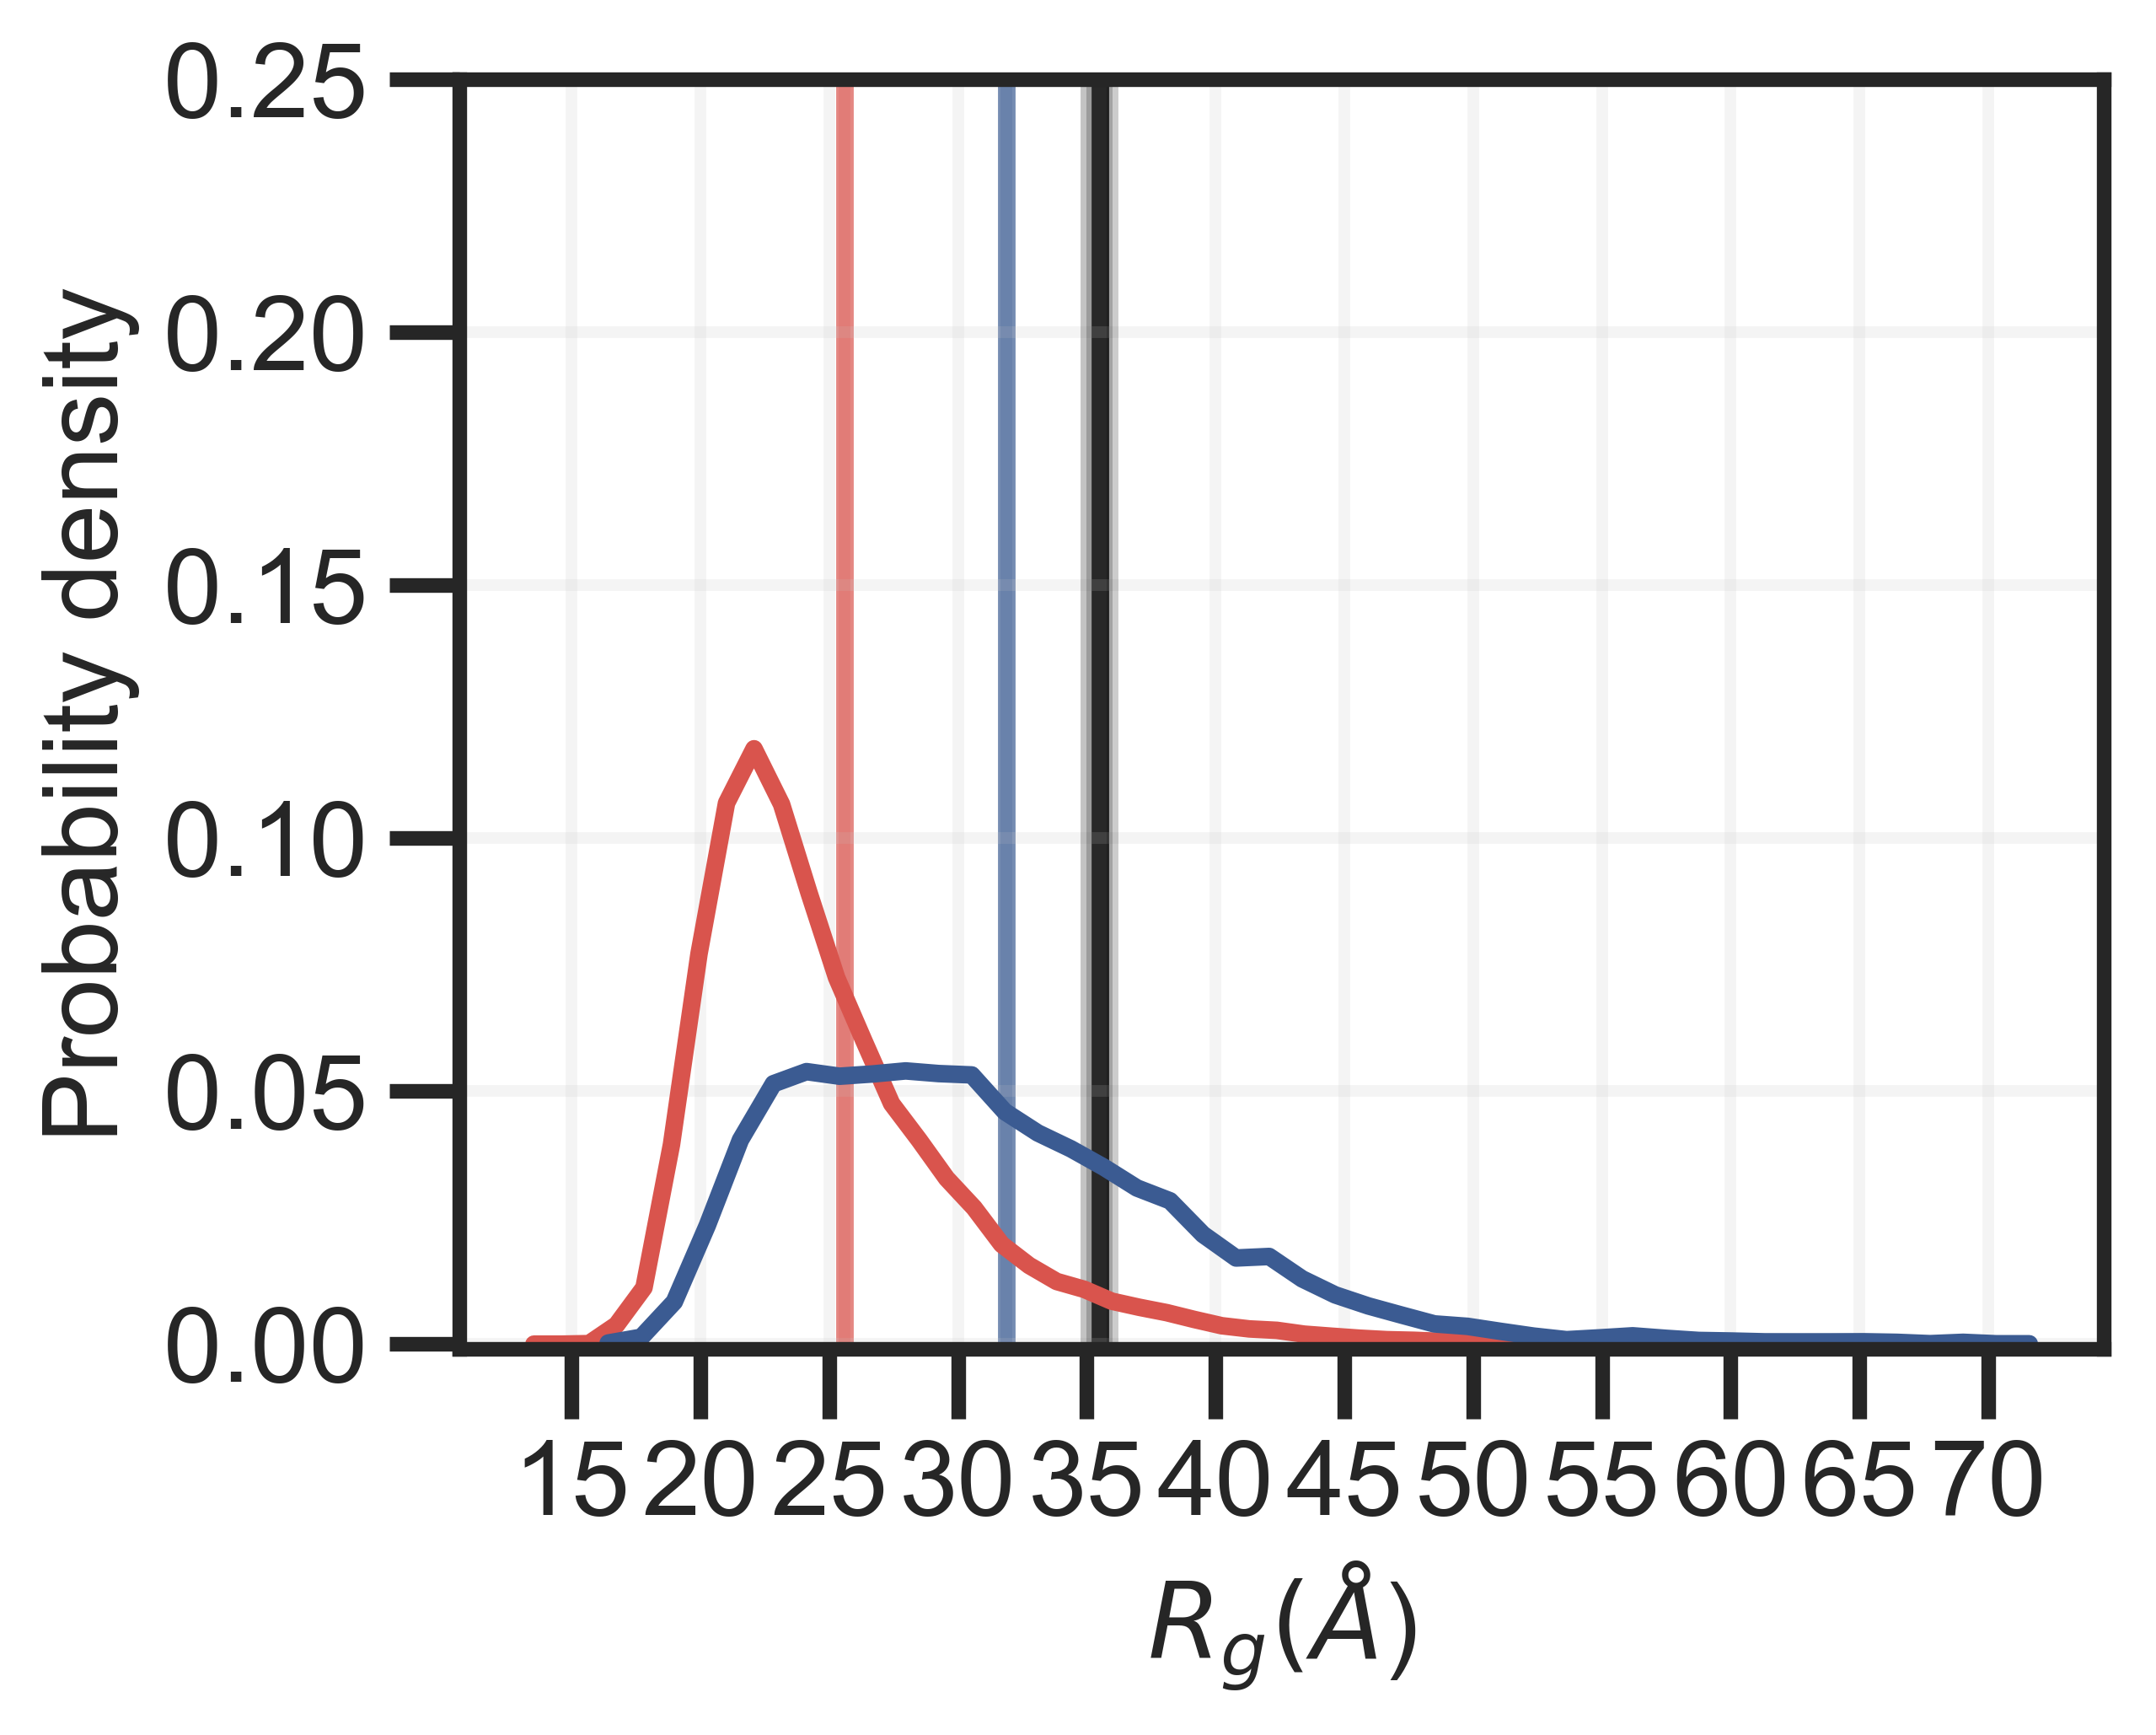

In [35]:
# We first load the data

data = Rg*Rg
data1 = Rg

weights1 = np.loadtxt('a99SB-disp/example1_{}_weights.dat'.format(t), usecols=1)
wig1=np.reshape(np.array(weights1),[-1, 1])

data1w=np.sqrt(np.sum(data*wig1))

# Set the figure style
sns.set_style("ticks")
sns.set_context("poster")
mpl.rcParams['figure.dpi'] = 500
fig,ax = plt.subplots(1,1,figsize=(5,4))
plt.rcParams['figure.constrained_layout.use'] = True
ax.set_ylabel("Probability density",fontsize=18)
ax.set_xlabel("$R_g (\AA$)",fontsize=18)
ax.tick_params(axis='both', labelsize=18)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
c1 = sns.xkcd_rgb["black"]
c2 = sns.xkcd_rgb["pale red"]
c3 = sns.xkcd_rgb["denim blue"]

hist_0 = []
hist_post = []
binsize = n_frames//n_bins

sqrt_nbins = 1./np.sqrt(n_bins)
meanRgaa=[]
meanRga=[]
meanRgb=[]
bins = np.linspace(13,60,45)
rgw, ds=np.histogram(data1,density=True,bins=44,weights=wig1)
for j in range(n_bins):
    
    # read weights
    weights = np.loadtxt('a99SB-disp/example2_{}_weights.dat'.format(j), usecols=1)
    wig=np.reshape(np.array(weights),[-1, 1])
    Rgb = np.sqrt(np.mean(data[j*binsize:(j+1)*binsize]))
    Rga = np.sqrt(np.sum(wig*(data[j*binsize:(j+1)*binsize])))
    Rgaa =(np.sum(wig*data1[j*binsize:(j+1)*binsize]))
    meanRgb.append(Rgb)
    meanRga.append(Rga)
    meanRgaa.append(Rgaa)
    #print(Rga)
    hh_0, ee_0 = np.histogram(data1[j*binsize:(j+1)*binsize],density=True,bins=bins)
    hist_0.append(hh_0)
    
    hh_post, ee_1 = np.histogram(data1[j*binsize:(j+1)*binsize],density=True,bins=bins,weights=wig)
    hist_post.append(hh_post)

    
# plot   

xx = 0.5*(ee_0[1:]+ee_0[:-1])
xxx= 0.5*(ds[1:]+ds[:-1])
avg_0 = np.average(hist_0,axis=0)
sem_0 = sqrt_nbins*np.std(hist_0,axis=0,ddof=2)

ax.plot(xx,avg_0,color=c2,ls='-',lw=3)
ax.fill_between(xx,avg_0-sem_0,avg_0+sem_0,color=c2,alpha=0.2)
avg_post = np.average(hist_post,axis=0)
sem_post = sqrt_nbins*np.std(hist_post,axis=0,ddof=1)
ax.plot(xxx,rgw,color=c3,ls='-',lw=3)

ax.fill_between(xxx,rgw-sem_post,rgw+sem_post,color=c3,alpha=0.2)
#print(np.std(meanRga)*sqrt_nbins)
ax.axvspan((Rg_Exp.nominal_value)-Rg_Exp.std_dev,Rg_Exp.nominal_value+Rg_Exp.std_dev, alpha=0.2, color=c1)
plt.axvline(Rg_Exp.nominal_value,ls='-',color=c1,alpha=0.8,lw=3,
            zorder=0,label='Experiment $R_g$ 35.5 $\AA$ $\pm$ 0.5' )

ax.axvspan(np.sqrt(np.mean(Rg*Rg))-np.std(meanRgb)*sqrt_nbins,np.sqrt(np.mean(Rg*Rg))+np.std(meanRgb)*sqrt_nbins, 
           alpha=0.2, color=c2)
ax.axvspan(data1w-np.std(meanRga)*sqrt_nbins,data1w+np.std(meanRga)*sqrt_nbins, 
           alpha=0.2, color=c3)
#print (np.sqrt(np.mean(Rg*Rg)))
#print (meanRgb)
plt.axvline(np.round(np.sqrt(np.mean(Rg*Rg)),decimals=2),ls='-',
            c=c2,alpha=0.7,lw=3,zorder=0,label='Simulation   $\sqrt{<R_g^2>}$ ' + 
             np.str(np.round(np.sqrt(np.mean(data)),decimals=2))+ ' $\AA$ '+ np.str(np.std(meanRgb)*sqrt_nbins))
plt.axvline(np.round(data1w,decimals=2),ls='-',
            color=c3,alpha=0.7,lw=3,zorder=0,label='Reweighted $\sqrt{<R_g^2>}$ '+ 
             np.str(np.round(data1w,decimals=2))+ ' $\AA$ '+ np.str(np.std(meanRga)*sqrt_nbins))
# plt.axvline(np.round(np.mean(data1),decimals=2),ls='--',
#             color=c2,alpha=0.7,lw=3,zorder=0,label='Simulation $<R_g>$ '+ 
#              np.str(np.round(np.mean(data1),decimals=2))+ ' $\AA$')
# plt.axvline(np.round(np.mean((meanRgaa)),decimals=2),ls='--',
#             color=c3,alpha=0.7,lw=3,zorder=0,label='Reweighted  $<R_g>$ '+ 
#              np.str(np.round(np.mean((meanRgaa)),decimals=2))+ ' $\AA$')
plt.ylim(-0.001,0.25)
plt.grid(alpha=0.2)
#plt.legend()
name='a99SB-disp/' + 'Rg' + '.png' 
plt.savefig(name,dpi=500)
print('sim: ',np.sqrt(np.mean(data)),'rew: ',data1w)
print('Err_sim: ',np.std(meanRgb)*sqrt_nbins,'Err_rew: ',np.std(meanRga)*sqrt_nbins)

plt.show()




(73117, 1) (73117, 1)


/Users/musti/Downloads/PREFIX=/Users/musti/Applications/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/musti/Downloads/PREFIX=/Users/musti/Applications/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:130: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


sim:  27.704315580423188 rew:  30.84077183408419
Err_sim:  0.0 Err_rew:  0.0


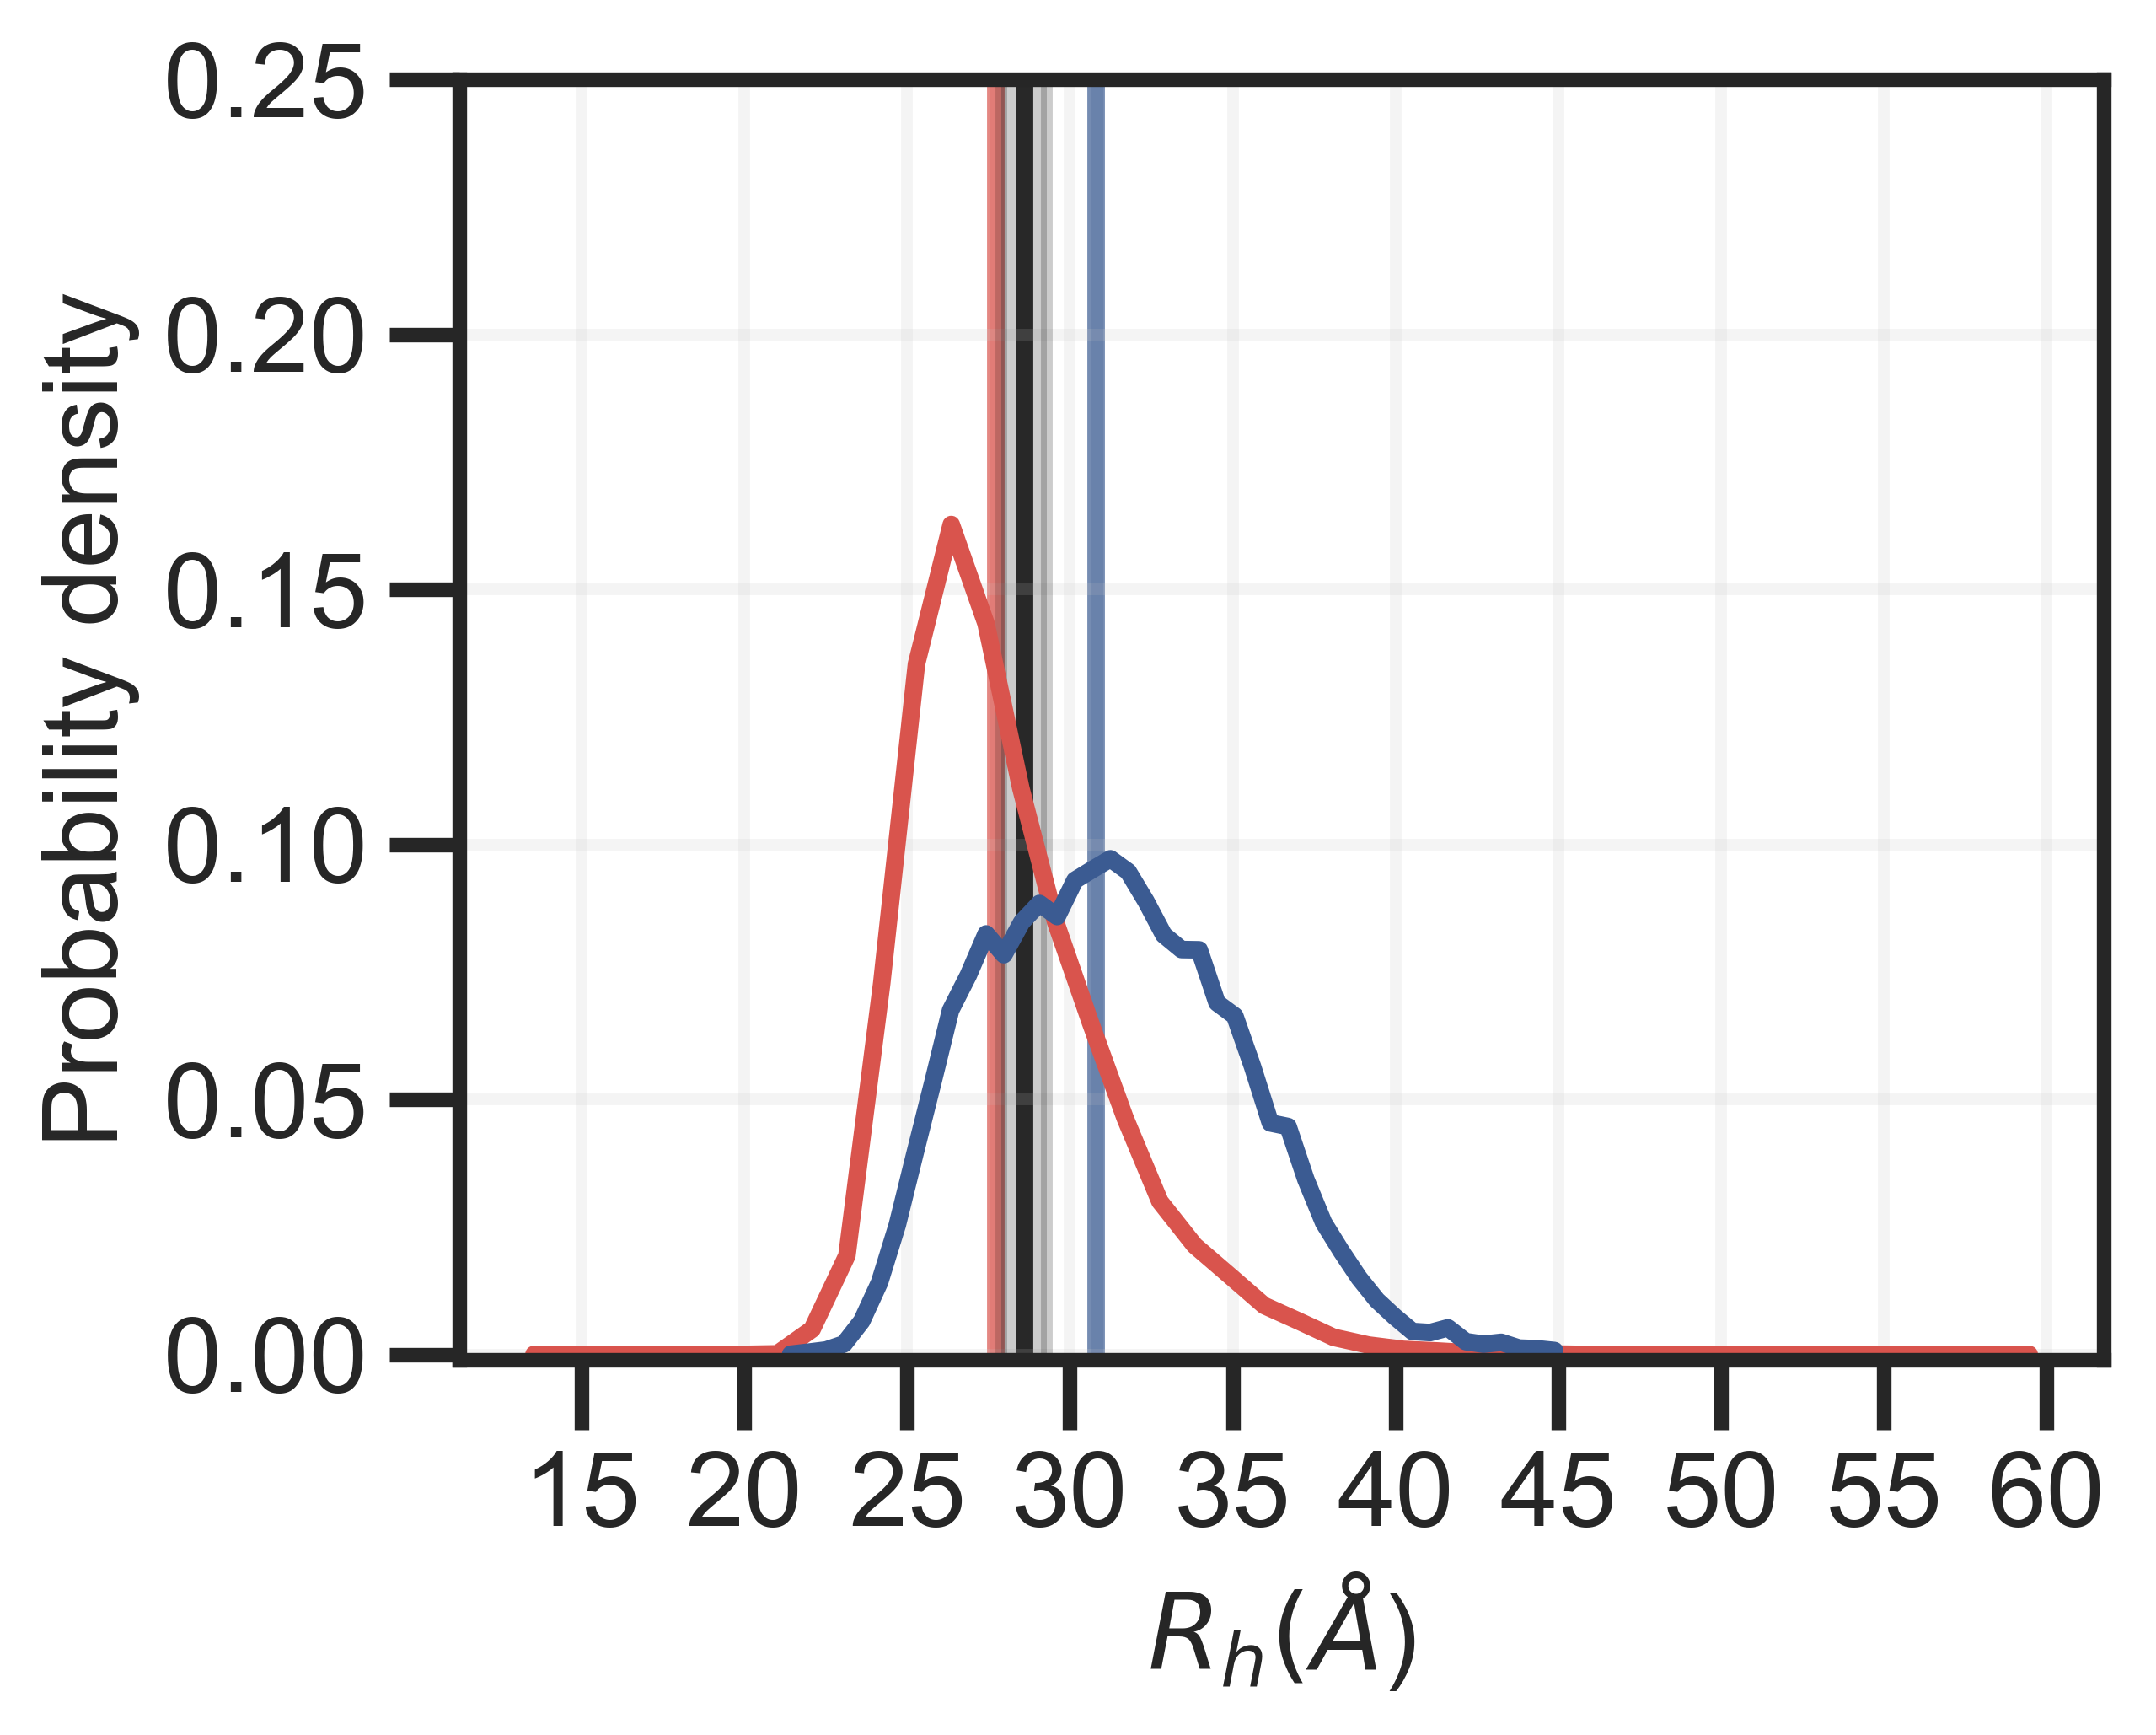

In [36]:
# load data
data2 =  I_Rh
data3 = Rh
data2w=-1/np.log(np.sum(data2*wig1))
data2uw=-1/np.log(np.mean(data2))
# sns.set_style("white")
# sns.set_context("paper")
mpl.rcParams['figure.dpi'] = 500

fig,ax = plt.subplots(1,1,figsize=(5,4))
plt.rcParams['figure.constrained_layout.use'] = True
ax.set_ylabel("Probability density",fontsize=18)
ax.set_xlabel("$R_h (\AA$)",fontsize=18)
ax.tick_params(axis='both', labelsize=18)

ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
c1 = sns.xkcd_rgb["black"]
c2 = sns.xkcd_rgb["pale red"]
c3 = sns.xkcd_rgb["denim blue"]
hist_0 = []
hist_post = []
binsize = n_frames//n_bins
sqrt_nbins = 1./np.sqrt(n_bins)
meanRgab=[]
meanRha=[]
meanRhb=[]
bins = np.linspace(13,60,45)
print(wig1.shape,data3.shape)
rhw, ds1=np.histogram(data3,density=True,bins=44,weights=wig1)


for j in range(n_bins):
    # read weights
    weightsrh = np.loadtxt('a99SB-disp/example2_{}_weights.dat'.format(j), usecols=1)
    wig=np.reshape(np.array(weights),[-1, 1])
    Rhb = -1./np.log((np.mean(data2[j*binsize:(j+1)*binsize])))
    Rha =-1/np.log((np.sum(wig*data2[j*binsize:(j+1)*binsize])))
    Rgab =(np.sum(wig*data3[j*binsize:(j+1)*binsize]))
    meanRhb.append(Rhb)
    meanRha.append(Rha)
    meanRgab.append(Rgab)
    hh_0, ee_0 = np.histogram(data3[j*binsize:(j+1)*binsize],density=True,bins=bins)
    hist_0.append(hh_0)
    hh_post, ee_1 = np.histogram(data3[j*binsize:(j+1)*binsize],density=True,bins=bins,weights=wig)    
    hist_post.append(hh_post)
#plot
xx = 0.5*(ee_0[1:]+ee_0[:-1])
xxx1= 0.5*(ds1[1:]+ds1[:-1])
avg_0 = np.average(hist_0,axis=0)
sem_0 = sqrt_nbins*np.std(hist_0,axis=0,ddof=1)
ax.plot(xx,avg_0,color=c2,ls='-', lw=3)
ax.fill_between(xx,avg_0-sem_0,avg_0+sem_0,color=c2,alpha=0.2)
avg_post = np.average(hist_post,axis=0)
sem_post = sqrt_nbins*np.std(hist_post,axis=0,ddof=1)
ax.plot(xxx1,rhw,color=c3,ls='-', lw=3)
ax.fill_between(xxx1,rhw-sem_post,rhw+sem_post,color=c3,alpha=0.2)

ax.axvspan(Rh_Exp.nominal_value-0.7,Rh_Exp.nominal_value+0.7, alpha=0.2, color=c1)
plt.axvline(Rh_Exp.nominal_value,ls='-',color=c1,alpha=0.8,lw=3,zorder=0,label='Experiment 29.0 $\AA$ $\pm$ 0.04' )
ax.axvspan(data2uw-np.std(meanRhb)*sqrt_nbins,data2uw+np.std(meanRhb)*sqrt_nbins, alpha=0.2, color=c2)
ax.axvspan(data2w-np.std(meanRha)*sqrt_nbins,data2w+np.std(meanRha)*sqrt_nbins, alpha=0.2, color=c3)

plt.axvline(np.round(data2uw,decimals=1),ls='-',c=c2,alpha=0.7,lw=3,zorder=0,label='Simulation ' + 
             np.str(np.round(data2uw,decimals=1))+ ' $\AA$ ' + np.str(np.std(meanRhb)*sqrt_nbins))
plt.axvline(np.round(data2w,decimals=1),ls='-',color=c3,alpha=0.7,lw=3,zorder=0,label='Reweighted '+ 
             np.str(np.round(data2w,decimals=1))+ ' $\AA$ ' + np.str(np.std(meanRha)*sqrt_nbins))


plt.ylim(-0.001,0.25)


plt.grid(alpha=0.2)

name='a99SB-disp/' + 'Rh' + '.png' 
plt.savefig(name,dpi=500)
print('sim: ',data2uw,'rew: ',data2w)
print('Err_sim: ',np.std(meanRhb)*sqrt_nbins,'Err_rew: ',np.std(meanRha)*sqrt_nbins)
plt.show()

We now plot the calculated SAXS intensity before and after the reweight in comparson with the experimental saxs curve. We load the saved SAXS curve before and and after in the reweighting step(file `example2_0_.stats.dat`) and plot:

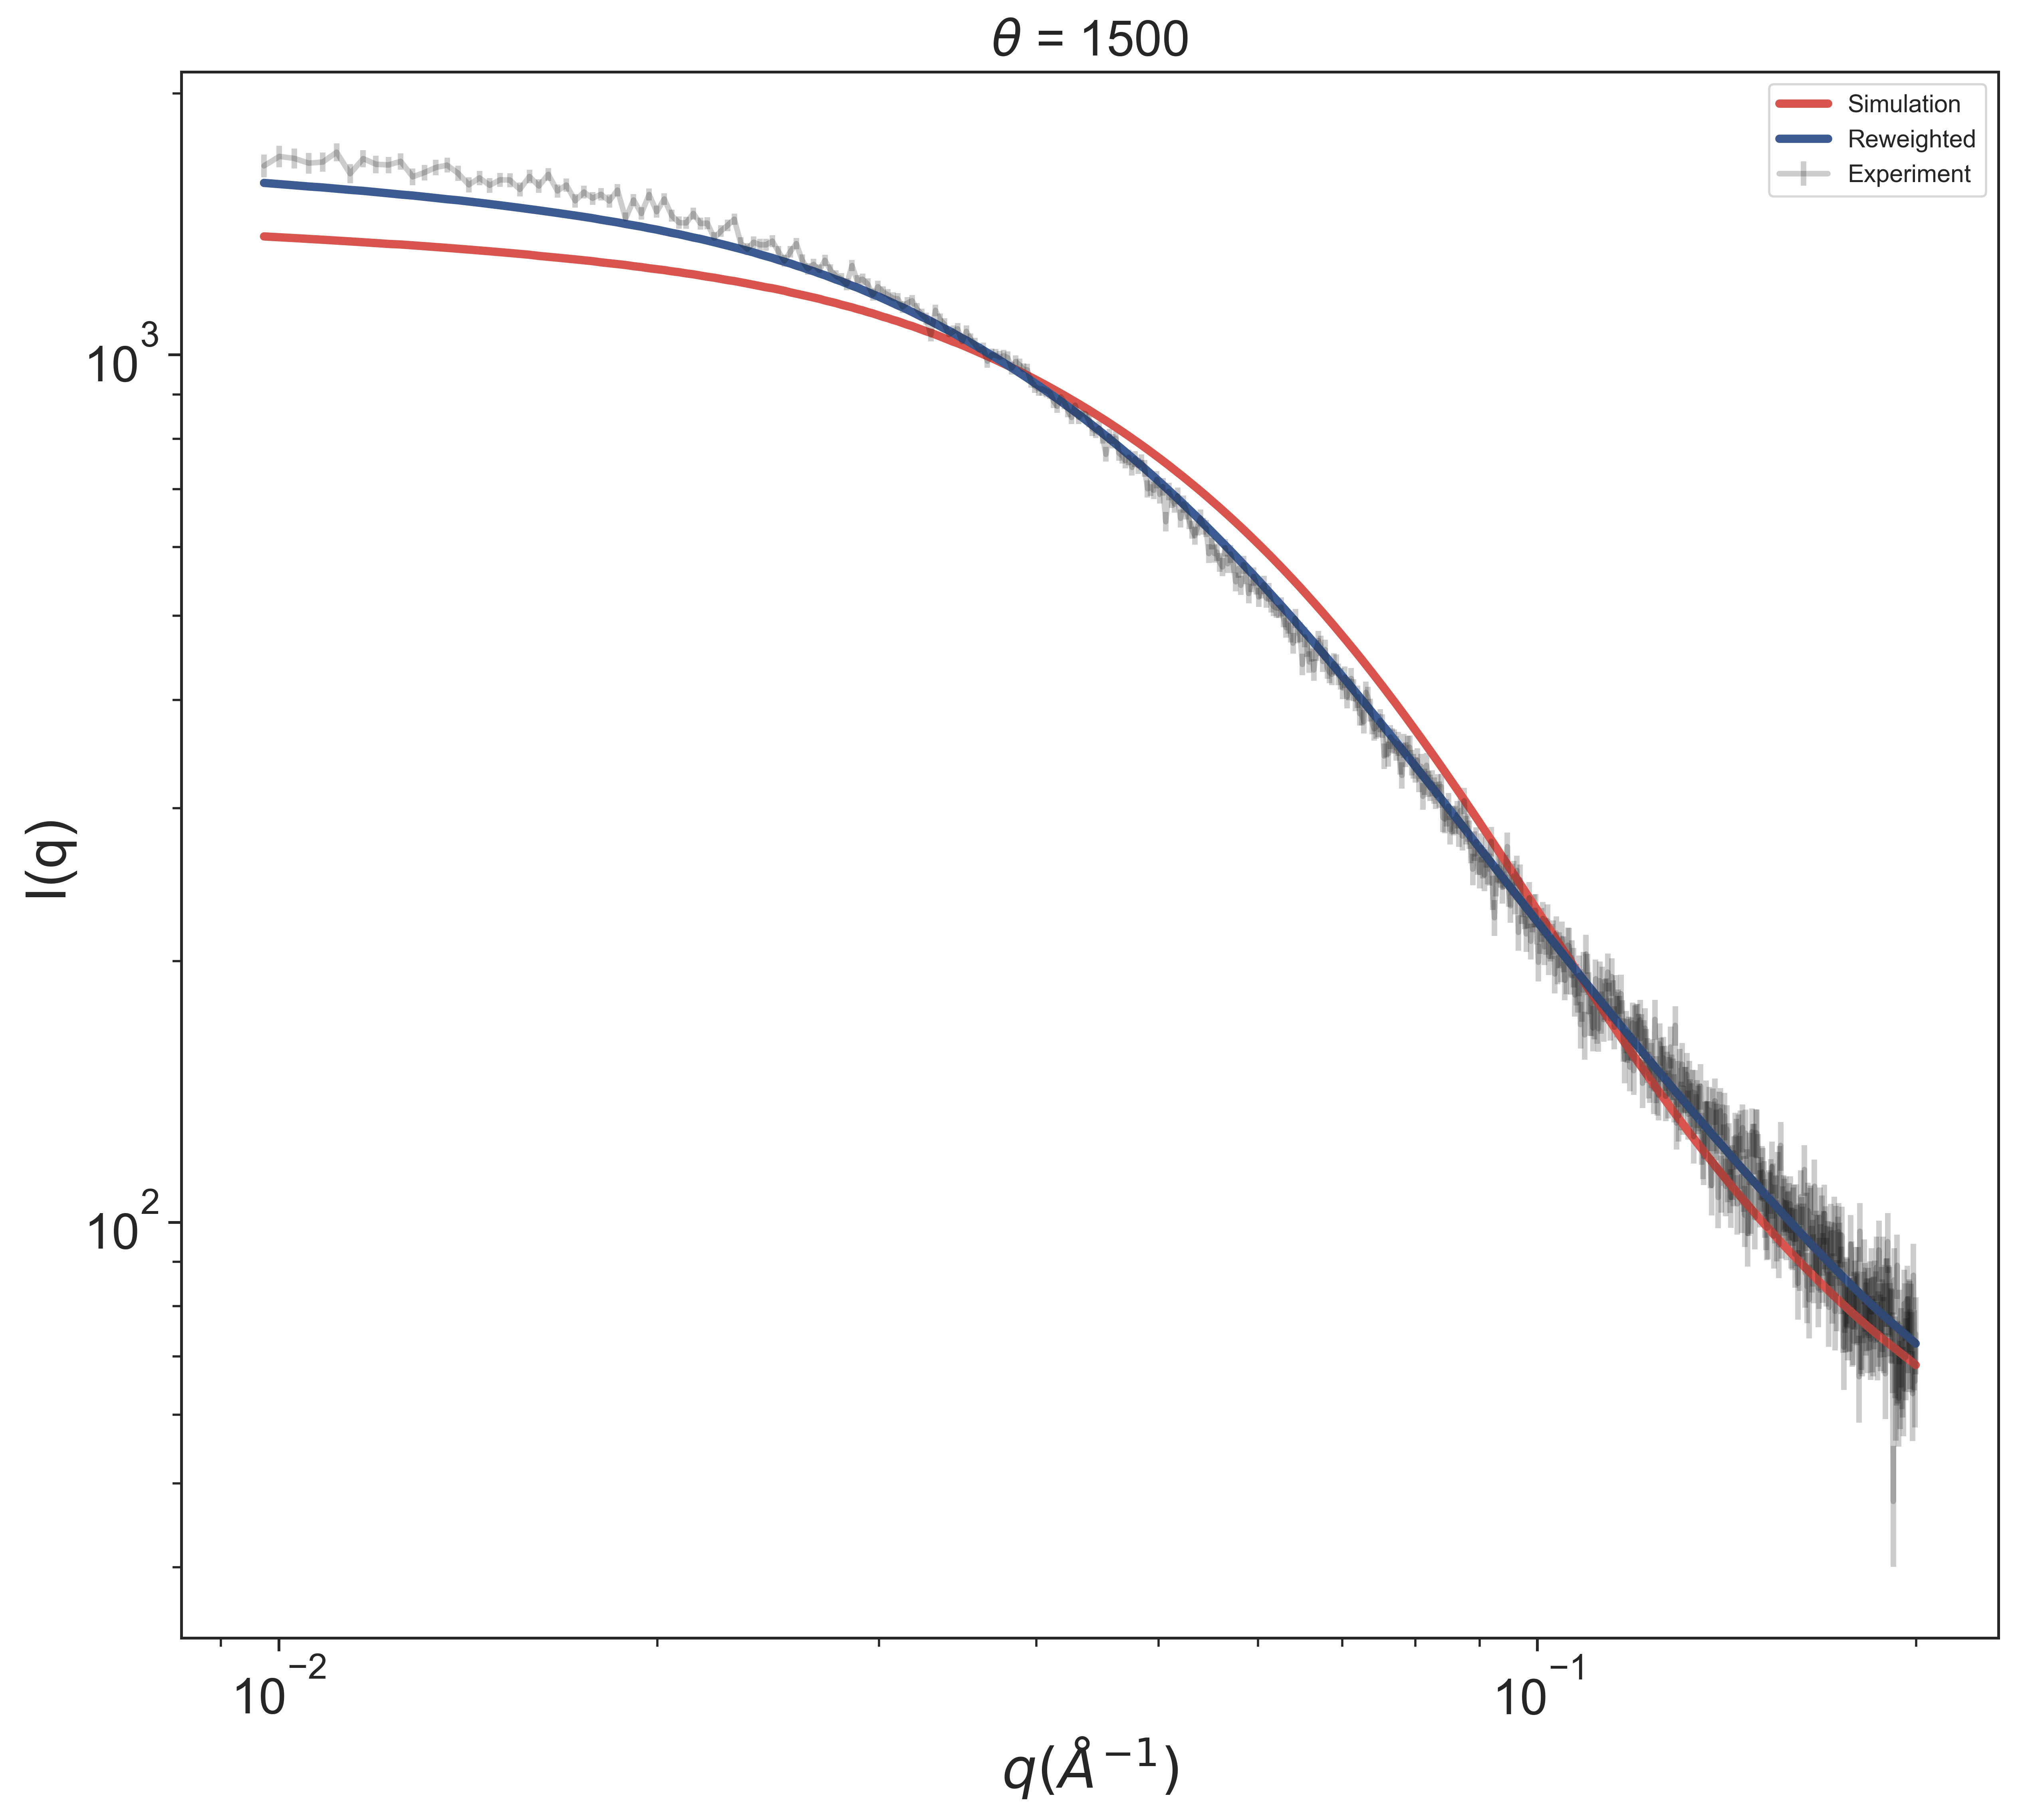

In [42]:
### load SAXS profiles saved by BME
sts = np.loadtxt("a99SB-disp/example1_0_.stats.dat");
print(len(sts))
## plot figure
#sns.set_style("white")
sns.set_style("ticks")
sns.set_context("poster")
mpl.rcParams['figure.dpi'] =500
plt.rcParams['figure.constrained_layout.use'] = True


fig,ax = plt.subplots(1,1,figsize=(5,4))
plt.loglog()




ax.plot(sts[:,0],sts[:,3],label="Simulation",c=c2,lw=2 )
ax.plot(sts[:,0],sts[:,4],label="Reweighted" ,c=c3,lw=2)
ax.errorbar(sts[:,0],sts[:,1],yerr=sts[:,2],alpha=.7,label="Experiment", c='#C1CDCD',lw=2)
ax.set_title(r"$\theta$ = " + np.str(theta), fontsize=18)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.set_xlabel("$q (\AA^{-1})$",fontsize=20)

ax.set_ylabel("I(q)",fontsize=20)
#plt.legend()
name='a99SB-disp/' + 'saxs' + '.png' 
plt.savefig(name,dpi=500)
plt.show()

688


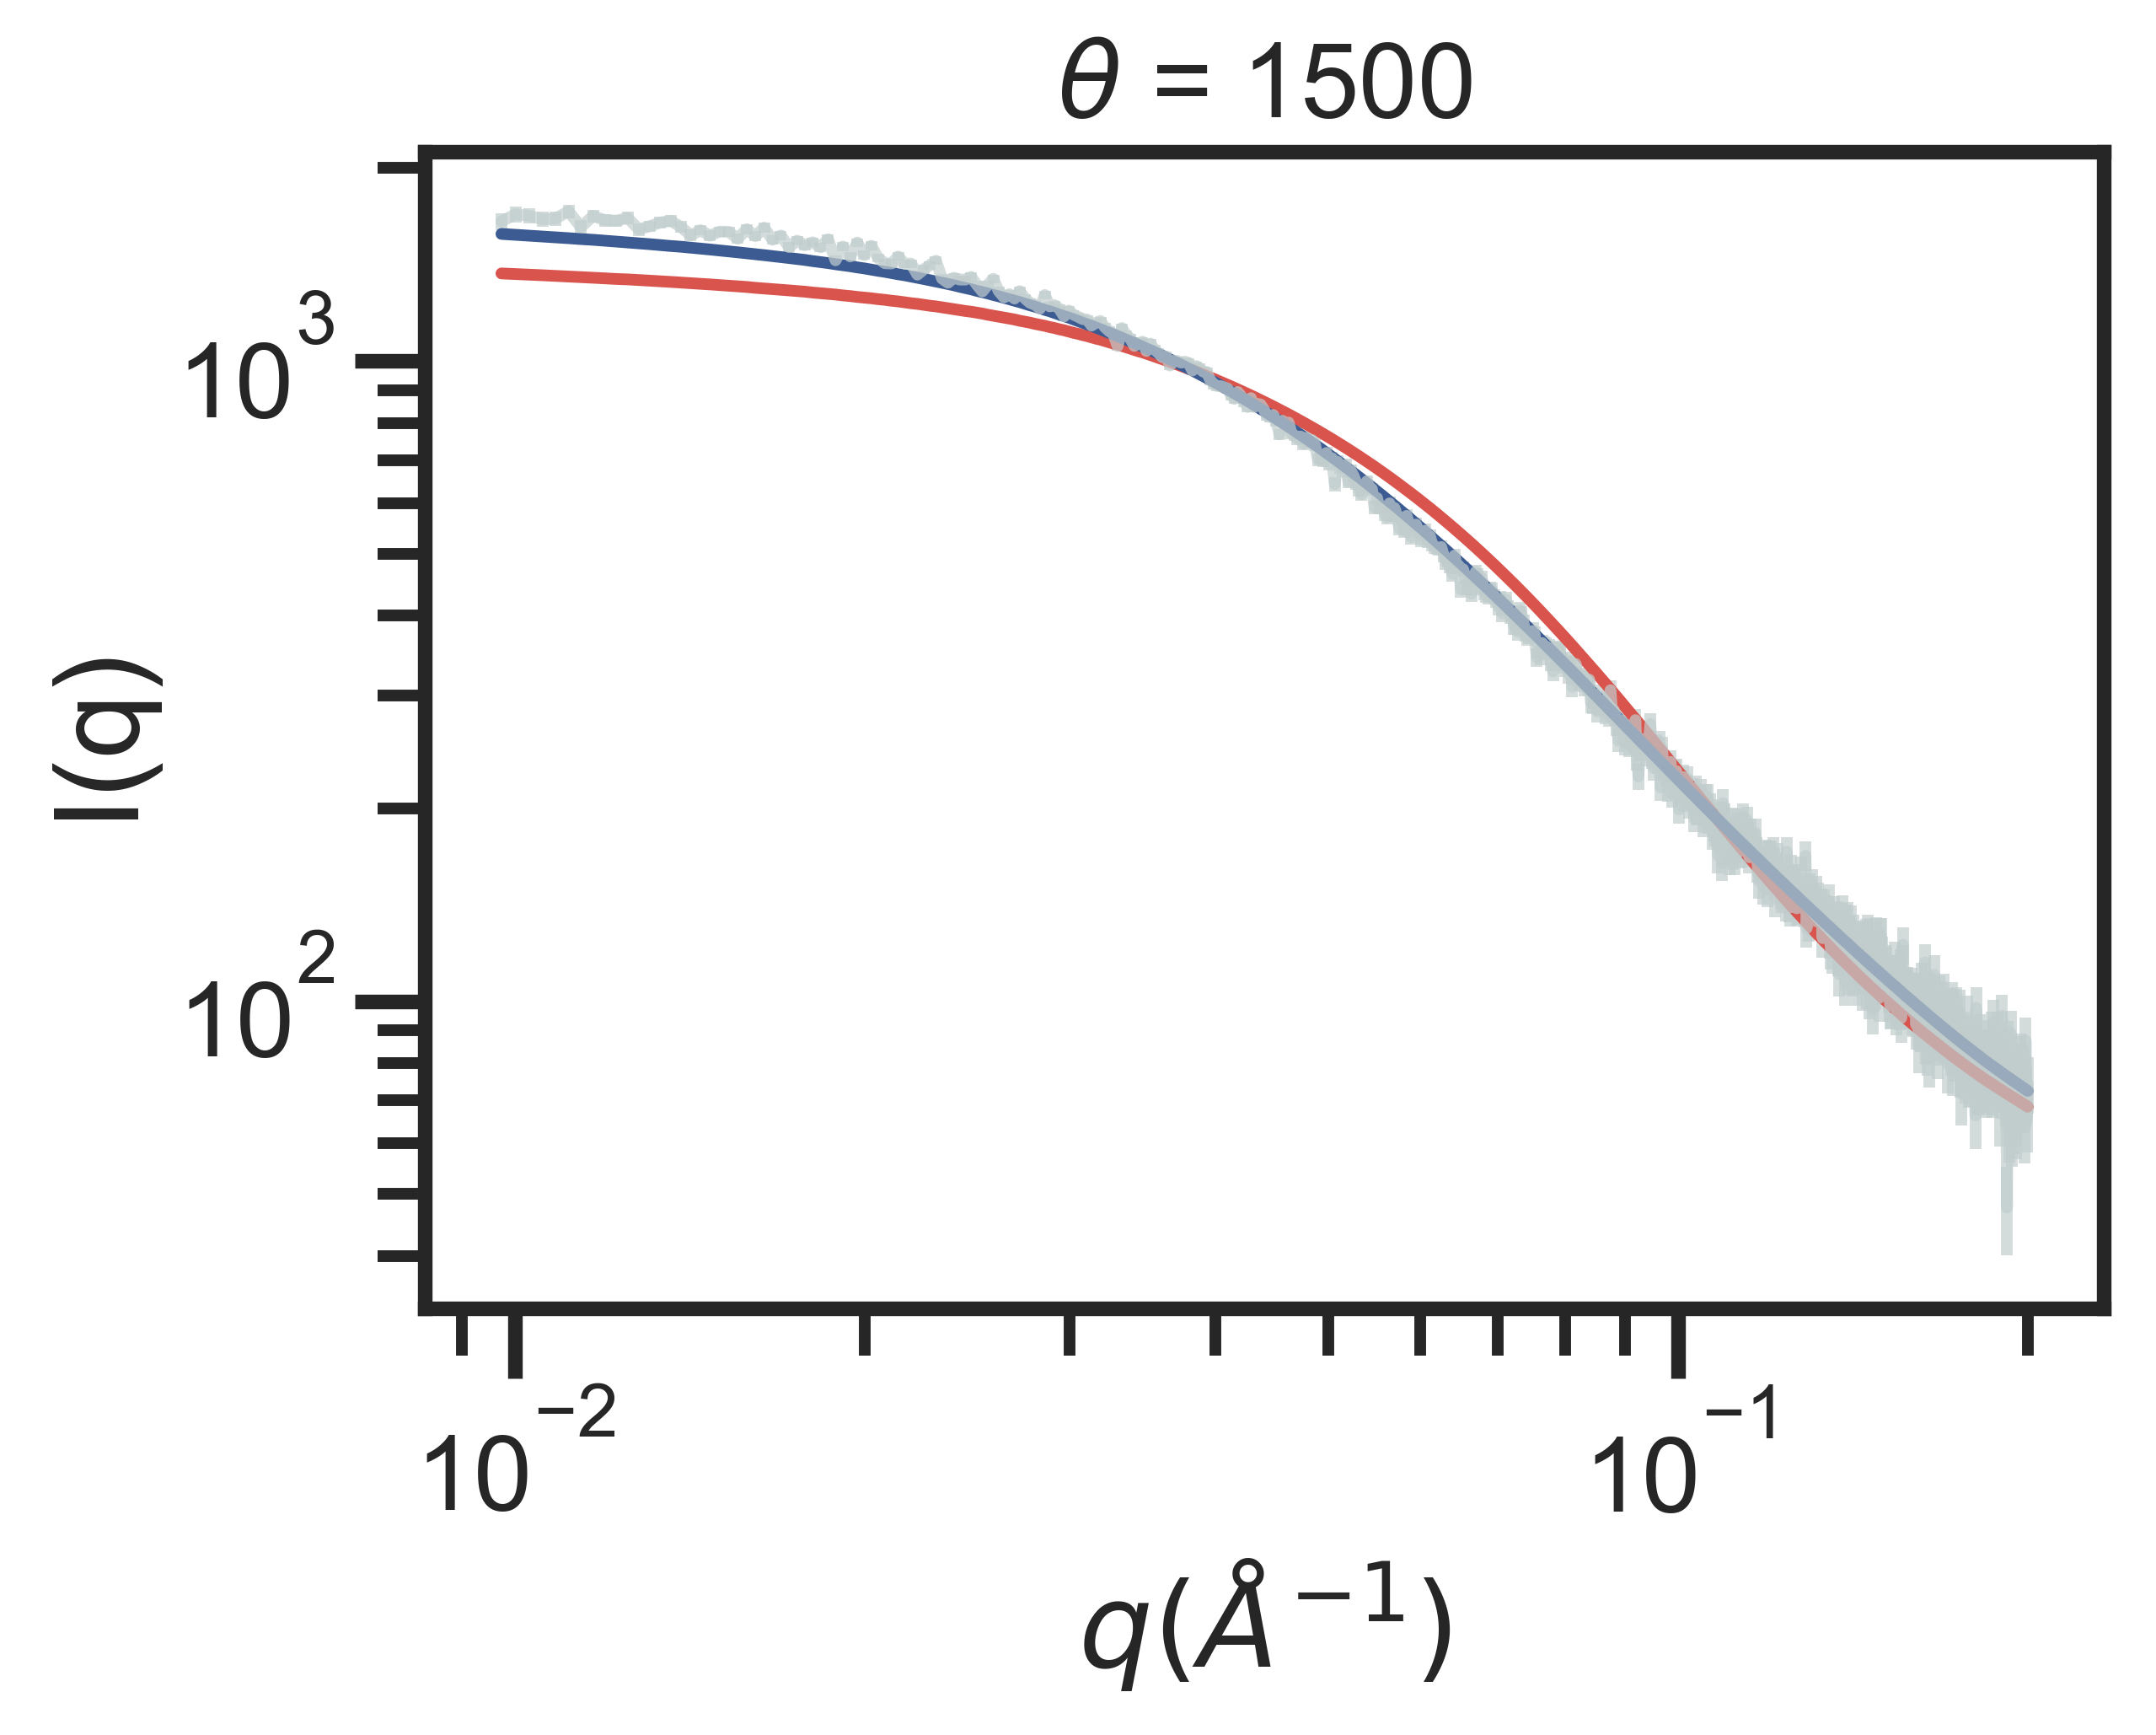